## Figure tracer transport 

In [3]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [15]:
sns.set_context('paper')
sns.set_style('white')
plt.rcParams.update({'font.size': 11})

In [39]:
def plot_transports_CS(g0,g1,g2,g3,g4,g5, dfcan, dfdif, color, lab):
    
    ax0 = plt.subplot(g0)
    ax1 = plt.subplot(g1)
    ax2 = plt.subplot(g2)
    ax3 = plt.subplot(g3)
    ax4 = plt.subplot(g4)
    ax5 = plt.subplot(g5)
    
    axs = [ax0,ax1,ax2,ax3,ax4,ax5]
      
    for ax in axs:
        ax.axhline(0, color='gold')
        ax.tick_params(axis='y', pad=0)
        ax.tick_params(axis='x', pad=0.05)
        ax.grid(which='both',color='0.9', linestyle='-')
        ax.set_ylim(-15, 15)
        ax.set_xlabel('Days', labelpad=0)
        ax.set_xticks([0,3,6,9])
    for ax in axs[1:]:
        ax.set_yticks([-10,-5,0,5,10])
        ax.set_yticklabels(['','','','','',''])
   
    # Tracers
    vertical =  dfcan.Vert_adv_trans_sb # only advective parts, ignoring diffusve for now      
    ax0.plot(np.arange(1,19,1)/2.0,(vertical)/1E5,color=color, label=lab)
    ax1.plot(np.arange(1,19,1)/2.0,(dfcan.CS1_adv_trans+dfcan.CS2_adv_trans)/1E5,color=color, label=lab)
    ax2.plot(np.arange(1,19,1)/2.0,(dfcan.CS3_adv_trans )/1E5,color=color, label=lab)
    ax3.plot(np.arange(1,19,1)/2.0,(dfcan.CS4_adv_trans+dfcan.CS5_adv_trans)/1E5,color=color, label=lab)
    ax4.plot(np.arange(1,19,1)/2.0,(dfcan.CS6_adv_trans )/1E5,color=color, label=lab)

    total = ( (dfcan.CS1_adv_trans ) +
              (dfcan.CS2_adv_trans ) +
              (dfcan.CS3_adv_trans ) +
              (dfcan.CS4_adv_trans ) +
              (dfcan.CS5_adv_trans ) +
              (dfcan.CS6_adv_trans ) +
               vertical)

    ax5.plot(np.arange(1,19,1)/2.0,total/1E5,color=color, label=lab)
       
def plot_can_effect(gs_c, dfcan, dfdif, dfcanNoC, dfdifNoC, color, lab):
    ax = plt.subplot(gs_c, xticks=[])
    ax.axhline(0, color='gold')
    canyon = tot_trans(dfcan, dfdif)
    no_canyon = tot_trans(dfcanNoC, dfdifNoC)
    ax.plot(np.arange(1,19,1)/2.0,(canyon-no_canyon)/1E5,color=color, label=lab)
    ax.tick_params(axis='y', pad=0.1)
    ax.grid(which='both',color='0.9', linestyle='-')
    ax.yaxis.tick_right()
    return(ax)
def tot_trans(dfcan, dfdif):
    vertical = (dfdif.Vert_dif_trans_sb + dfcan.Vert_adv_trans_sb)   
    total = ( (dfcan.CS1_adv_trans ) +
              (dfcan.CS2_adv_trans ) +
              (dfcan.CS3_adv_trans ) +
              (dfcan.CS4_adv_trans ) +
              (dfcan.CS5_adv_trans ) +
              (dfcan.CS6_adv_trans ) +
               vertical)
    return(total)

def plotCSPos(ax,CS1,CS2,CS3,CS4,CS5,CS6):
    ax.axvline(CS1,color='k',linestyle=':')
    ax.axvline(CS2,color='k',linestyle=':')
    ax.axvline(CS3,color='k',linestyle=':')
    ax.axvline(CS4,color='k',linestyle=':')
    ax.axvline(CS5,color='k',linestyle=':')
    ax.axvline(CS6,color='k',linestyle=':')

def plot_CS_slice(fig, gs_a, gs_b, t_slice, x_slice, x_slice_vert, y_slice_vert, z_slice, z_slice_zoom, y_ind, z_ind,
                  grid,Flux,FluxV,unit):
    
    ax_a = plt.subplot(gs_a)#,xticks=[])
    ax_b = plt.subplot(gs_b)#,xticks=[])
    
    areas = (np.expand_dims(grid.dxF.isel(X=x_slice,Y=y_ind).data,0))*(np.expand_dims(grid.drF.isel(Z=z_slice).data,1))

    # Zoom shelf   ---------------------------------------------------------------------------
    cnt = ax_a.contourf(grid.X.isel(X=x_slice)/1000,
                       grid.Z.isel(Z=z_slice_zoom),
                       Flux.isel(Zmd000104=z_slice_zoom, X=x_slice)/areas[z_slice_zoom,:],
                       16,cmap=cmo.cm.tarn,
                       vmax=np.max(Flux.isel(Zmd000104=z_slice_zoom,X=x_slice)/areas[z_slice_zoom,:]), 
                       vmin=-np.max(Flux.isel(Zmd000104=z_slice_zoom,X=x_slice)/areas[z_slice_zoom,:]))
    ax_a.contourf(grid.X.isel(X=x_slice)/1000,
                 grid.Z.isel(Z=z_slice_zoom),
                 grid.HFacC.isel(Z=z_slice_zoom,Y=y_ind,X=x_slice),
                 [0,0.1], colors='#a99582')

    cb_a = fig.colorbar(cnt, ax=ax_a)
    cb_a.ax.yaxis.set_tick_params(pad=1.5)

    ax_a.set_ylabel('Depth / m',labelpad=0.5)
    ax_a.text(0.001,0.05,'%s' %unit,transform=ax_a.transAxes, fontsize=8, color='k',fontweight='bold')    

    # Vertical section ---------------------------------------------------------------------------
    cnt=ax_b.contourf(grid.X.isel(X=x_slice_vert)/1000,
                     grid.Y.isel(Y=y_slice_vert)/1000,
                     100*(FluxV.isel(X=x_slice_vert,Y=y_slice_vert).data)/(grid.rA[y_slice_vert,x_slice_vert]),
                     16,cmap=cmo.cm.tarn,
                     vmax= np.max(100*(FluxV.isel(X=x_slice_vert,Y=y_slice_vert).data)/(grid.rA[y_slice_vert,x_slice_vert])),
                     vmin=-np.max(100*(FluxV.isel(X=x_slice_vert,Y=y_slice_vert).data)/(grid.rA[y_slice_vert,x_slice_vert])))
    ax_b.contourf(grid.X.isel(X=x_slice_vert)/1000, 
                 grid.Y.isel(Y=y_slice_vert)/1000,
                 grid.HFacC.isel(Z=z_ind,X=x_slice_vert,Y=y_slice_vert),
                 [0,0.1], colors='#a99582')
    
    cb_b=fig.colorbar(cnt, ax=ax_b)#,ticks=[-2,-1,0,1,2,3,4])
    cb_b.ax.yaxis.set_tick_params(pad=1.5)
    ax_b.set_ylabel('C-S distance / km')
    ax_b.set_aspect(1)
    
    return(ax_a,ax_b)

In [7]:
#Exp
Grid = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc' 
GridOut = Dataset(Grid)

GridNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc' 
GridNoCOut = Dataset(GridNoC)

State = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc' 
StateNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/stateGlob.nc' 

In [20]:
units = ['$10^5$ $\mu$M m$^3$s$^{-1}$',
         '$10^5$ $\mu$mol kg$^{-1}$ m$^3$s$^{-1}$',
         '$10^5$ $\mu$M m$^3$s$^{-1}$',
         '$10^5$ nM m$^3$s$^{-1}$',
         '$10^5$ $\mu$mol kg$^{-1}$ m$^3$s$^{-1}$']
tracers = ['TR01', 'TR03','TR04','TR08','TR09']
tr_labels = ['Linear','Oxygen','Nitrate','Methane','DIC']

exps = ['UPW_10TR_BF2_AST/01_Ast03',
        'UPW_10TR_BF2_AST/03_Ast03_Argo',
        'UPW_10TR_BF4_BAR/01_Bar03',
        'UPW_10TR_BF4_BAR/03_Bar03_Path']

expsNoC = ['UPW_10TR_BF2_AST/02_Ast03_No_Cny',
           'UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo',
           'UPW_10TR_BF4_BAR/02_Bar03_No_Cny',
           'UPW_10TR_BF4_BAR/04_Bar03_No_Cny_Path']

colors = ['0.8', '0.6', '0.4', 'k']
labels = ['Astoria','Ast ARGO', 'Barkley', 'Bar Pathways']

In [9]:
t_slice = slice(10,20)
x_slice = slice(0,400)
x_slice_vert = slice(120,240)
y_slice_vert = slice(130,230)
z_slice = slice(0,80)
z_slice_zoom = slice(0,30)
y_ind = 130 # sb index
z_ind = 30 # sb index

/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


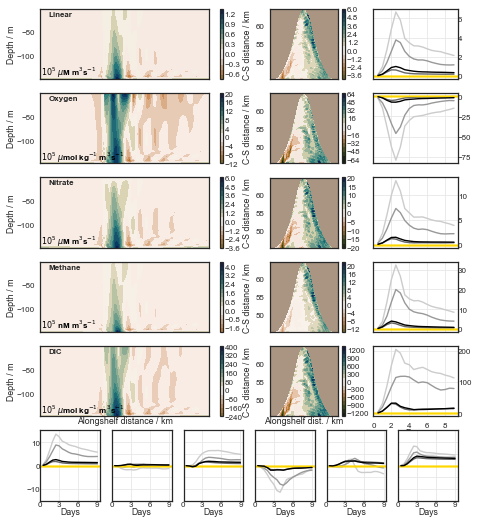

In [42]:
fig = plt.figure(figsize = (7.48,9.05))

gs = gspec.GridSpec(6, 1)
gs0 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0],hspace=0.15,wspace=0.15,width_ratios=[1,0.4,0.4])
gs1 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1],hspace=0.15,wspace=0.15,width_ratios=[1,0.4,0.4])
gs2 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[2],hspace=0.15,wspace=0.15,width_ratios=[1,0.4,0.4])
gs3 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[3],hspace=0.15,wspace=0.15,width_ratios=[1,0.4,0.4])
gs4 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[4],hspace=0.15,wspace=0.15,width_ratios=[1,0.4,0.4])
gs5 = gspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=gs[5])

ggs = [gs0, gs1,gs2,gs3,gs4]
grid = xr.open_dataset(Grid)

# This is horrible ------------------------------------------------------------------------------------
# - Linear
flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/Flux%sGlob.nc' %tracers[0])
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr01[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr01[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr01[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr01[t_slice,z_ind,:,:]+flux.DFrETr01[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

ax1,ax2 = plot_CS_slice(fig, gs0[0], gs0[1],t_slice, x_slice, x_slice_vert, y_slice_vert, 
                        z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV, units[0])
ax1.text(0.05,0.9,tr_labels[0],fontweight='bold',transform=ax1.transAxes)

# - Oxygen
flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/Flux%sGlob.nc' %tracers[1])
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr03[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr03[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr03[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr03[t_slice,z_ind,:,:]+flux.DFrETr03[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

ax3,ax4 = plot_CS_slice(fig, gs1[0], gs1[1],t_slice, x_slice, x_slice_vert, y_slice_vert, 
                        z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV, units[1])

ax3.text(0.05,0.9,tr_labels[1],fontweight='bold',transform=ax3.transAxes)

# -Nitratea
flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/Flux%sGlob.nc' %tracers[2])
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr04[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr04[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr04[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr04[t_slice,z_ind,:,:]+flux.DFrETr04[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

ax5,ax6 = plot_CS_slice(fig, gs2[0], gs2[1],t_slice, x_slice, x_slice_vert, y_slice_vert, 
                        z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV, units[2])
ax5.text(0.05,0.9,tr_labels[2],fontweight='bold',transform=ax5.transAxes)

# - Methane
flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/Flux%sGlob.nc' %tracers[3])
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr08[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr08[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr08[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr08[t_slice,z_ind,:,:]+flux.DFrETr08[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

ax7,ax8 = plot_CS_slice(fig, gs3[0], gs3[1],t_slice, x_slice, x_slice_vert, y_slice_vert, 
                        z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV, units[3])
ax7.text(0.05,0.9,tr_labels[3],fontweight='bold',transform=ax7.transAxes)

# - DIC
flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/Flux%sGlob.nc' %tracers[4])
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr09[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr09[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr09[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr09[t_slice,z_ind,:,:]+flux.DFrETr09[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

ax9,ax10 = plot_CS_slice(fig, gs4[0], gs4[1],t_slice, x_slice, x_slice_vert, y_slice_vert, 
                         z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV, units[4])
ax9.text(0.05,0.9,tr_labels[4],fontweight='bold',transform=ax9.transAxes)

#ax9.set_xticks([20,40,60,80,100,120,140])
#ax10.set_xticks([60,80,100])
ax9.set_xlabel('Alongshelf distance / km', labelpad=0)
ax10.set_xlabel('Alongshelf dist. / km', labelpad=0)
#------------------------------------------------------------------------------------------------------------
# - Canyon Effect
for tr, unit, tr_lab, gss in zip(tracers, units, tr_labels, ggs):
    for exp,expNoC, color, lab in zip(exps,expsNoC, colors, labels):
        # net canyon effect
        file = ('/data/kramosmu/results/TracerExperiments/%s/adv%s_CS_transports.nc' %(exp,tr))
        filedif = ('/data/kramosmu/results/TracerExperiments/%s/dif%s_CS_transports.nc' %(exp,tr))
        fileNoC = ('/data/kramosmu/results/TracerExperiments/%s/adv%s_CS_transports.nc' %(expNoC,tr))
        filedifNoC = ('/data/kramosmu/results/TracerExperiments/%s/dif%s_CS_transports.nc' %(expNoC,tr))

        dfcan = xr.open_dataset(file)
        dfdif = xr.open_dataset(filedif)
        dfcanNoC = xr.open_dataset(fileNoC)
        dfdifNoC = xr.open_dataset(filedifNoC)
        axx = plot_can_effect(gss[2], dfcan, dfdif, dfcanNoC, dfdifNoC, color, lab)
        axx.set_xticks([0,2,4,6,8])
        axx.set_xticklabels(['','','','',''])
    if tr_lab == 'DIC':
        axx.set_xticklabels([0,2,4,6,8])
        axx.set_xlabel('Days', labelpad=0)
        
#-------------------------------------------------------------------------------------------------------------
#- Linear profile cross-shelf transport through CS sections

for tr, unit, tr_lab, in zip(tracers[:1], units[:1], tr_labels[:1]):
    for exp, color, lab in zip(exps, colors, labels):
        # net canyon effect
        file = ('/data/kramosmu/results/TracerExperiments/%s/adv%s_CS_transports.nc' %(exp,tr))
        filedif = ('/data/kramosmu/results/TracerExperiments/%s/dif%s_CS_transports.nc' %(exp,tr))
        
        dfcan = xr.open_dataset(file)
        dfdif = xr.open_dataset(filedif)
        plot_transports_CS(gs5[0],gs5[1],gs5[2],gs5[3],gs5[4],gs5[5], dfcan, dfdif, color, lab)
        
#---------------------------------------------------------------------------------------------------------
# - aesthetics

plt.savefig('tracer_transport.eps',format='eps', bbox_inches='tight')